<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/Tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Sources</b>
  - https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/?__s=uwyrtqrb1sbk1eht5hsk
  - https://medium.com/towards-artificial-intelligence/using-tesseract-ocr-for-text-recognition-with-google-colab-1c4513b9d3e0
  - https://nanonets.com/blog/ocr-with-tesseract/
  - https://towardsdatascience.com/computer-vision-auto-grading-handwritten-mathematical-answersheets-8974744f72dd
  


In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!which tesseract
!mkdir images

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,670 kB/s)
debconf: unable to initi

In [3]:
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/ANA-1322.jpg -P images
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/image.png -P images
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/page.jpg -P images
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/receipt.jpg -P images

--2020-08-11 12:58:36--  https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/ANA-1322.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27892 (27K) [image/jpeg]
Saving to: ‘images/ANA-1322.jpg’

ANA-1322.jpg        100%[===================>]  27.24K  --.-KB/s    in 0.01s   

2020-08-11 12:58:37 (2.07 MB/s) - ‘images/ANA-1322.jpg’ saved [27892/27892]

--2020-08-11 12:58:38--  https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 464317 (453K) [image

In [4]:
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from scipy.spatial import ConvexHull
import pytesseract


Procedures

In [5]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect


def four_point_transform(image, pts):
  # obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped


def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

 
def minimum_bounding_rectangle(points):
    """
    https://gis.stackexchange.com/questions/22895/finding-minimum-area-rectangle-for-given-points
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2), dtype="int")
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval 


DrawBox


STEP 1: Edge Detection


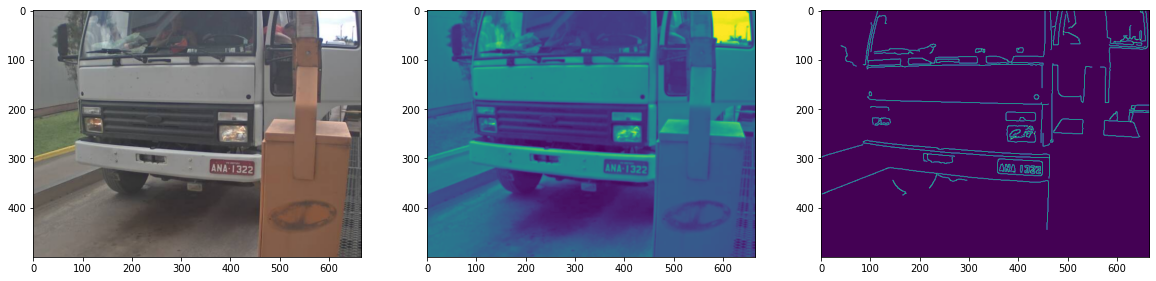

In [4]:
args={}
args['image'] = './images/ANA-1322.jpg'
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
_, axs = plt.subplots(1, 3, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip([image, gray,edged], axs):
    ax.imshow(img)
plt.show()


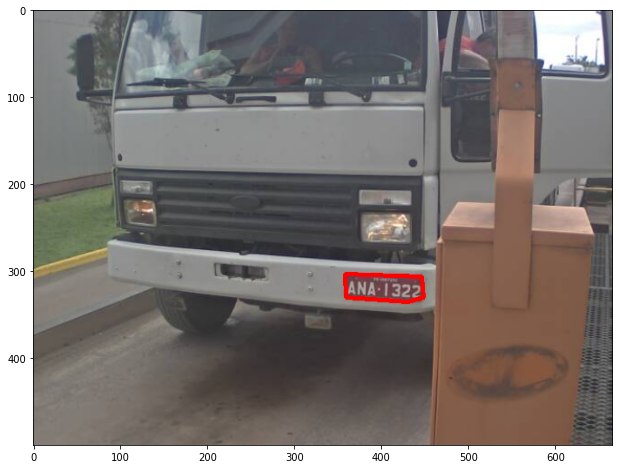

In [9]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  #corners = order_points(approx)
  #print (approx)

  # if our approximated contour has four points, then we
  # can assume that we have found our screen
  cv2.drawContours(image, [approx], -1, (255, 0, 0), 3)
  _ , axs = plt.subplots(1, 1, figsize=(12, 8))
  axs.imshow(image)
  break

Scanner

STEP 1: Edge Detection


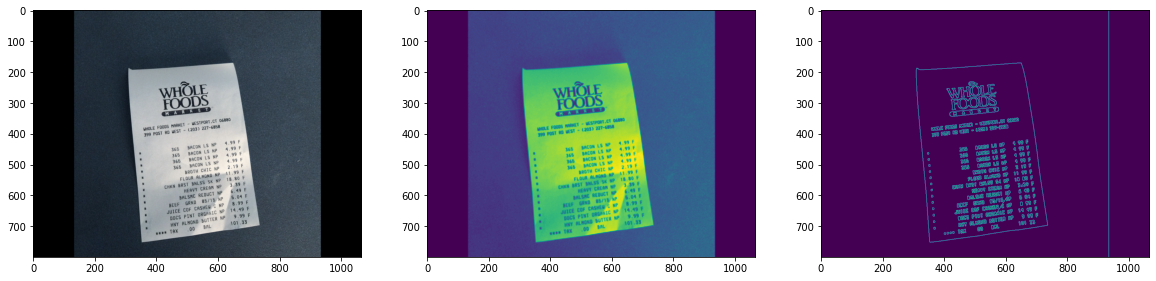

In [10]:
args={}
args['image'] = 'images/receipt.jpg'

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
image = imutils.rotate(image, 90)
ratio = image.shape[0] / 800.0
orig = image.copy()
image = imutils.resize(image, height = 800)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
_, axs = plt.subplots(1, 3, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip([image, gray, edged], axs):
    ax.imshow(img)
plt.show()


STEP 2: Find contours of paper


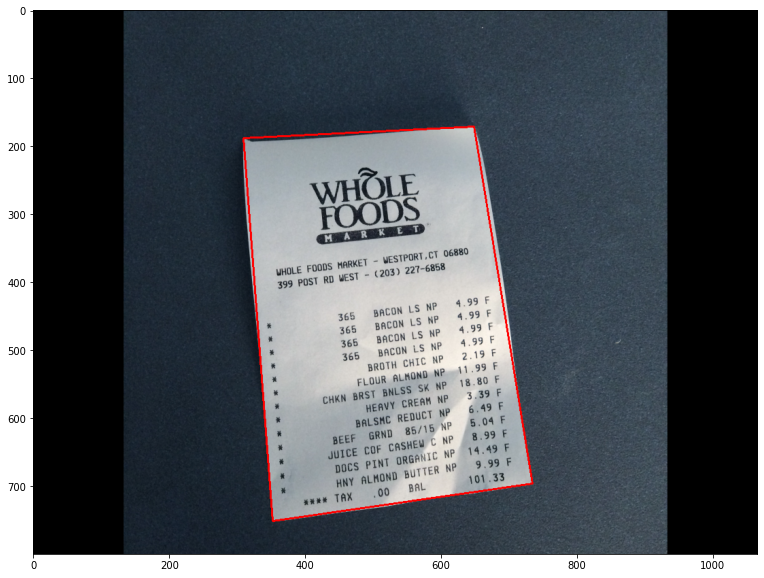

In [11]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (255, 0, 0), 2)
plt.figure(figsize=(20,10))
plt.imshow(image)



STEP 3: Apply perspective transform


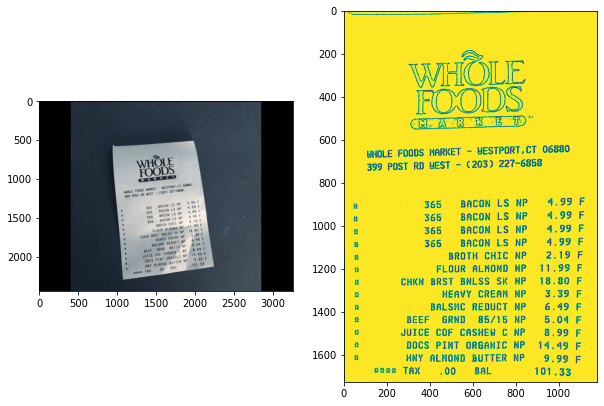

In [12]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
print("STEP 3: Apply perspective transform")
_, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip([orig, warped], axs):
    ax.imshow(img)
plt.show()

Tesseract

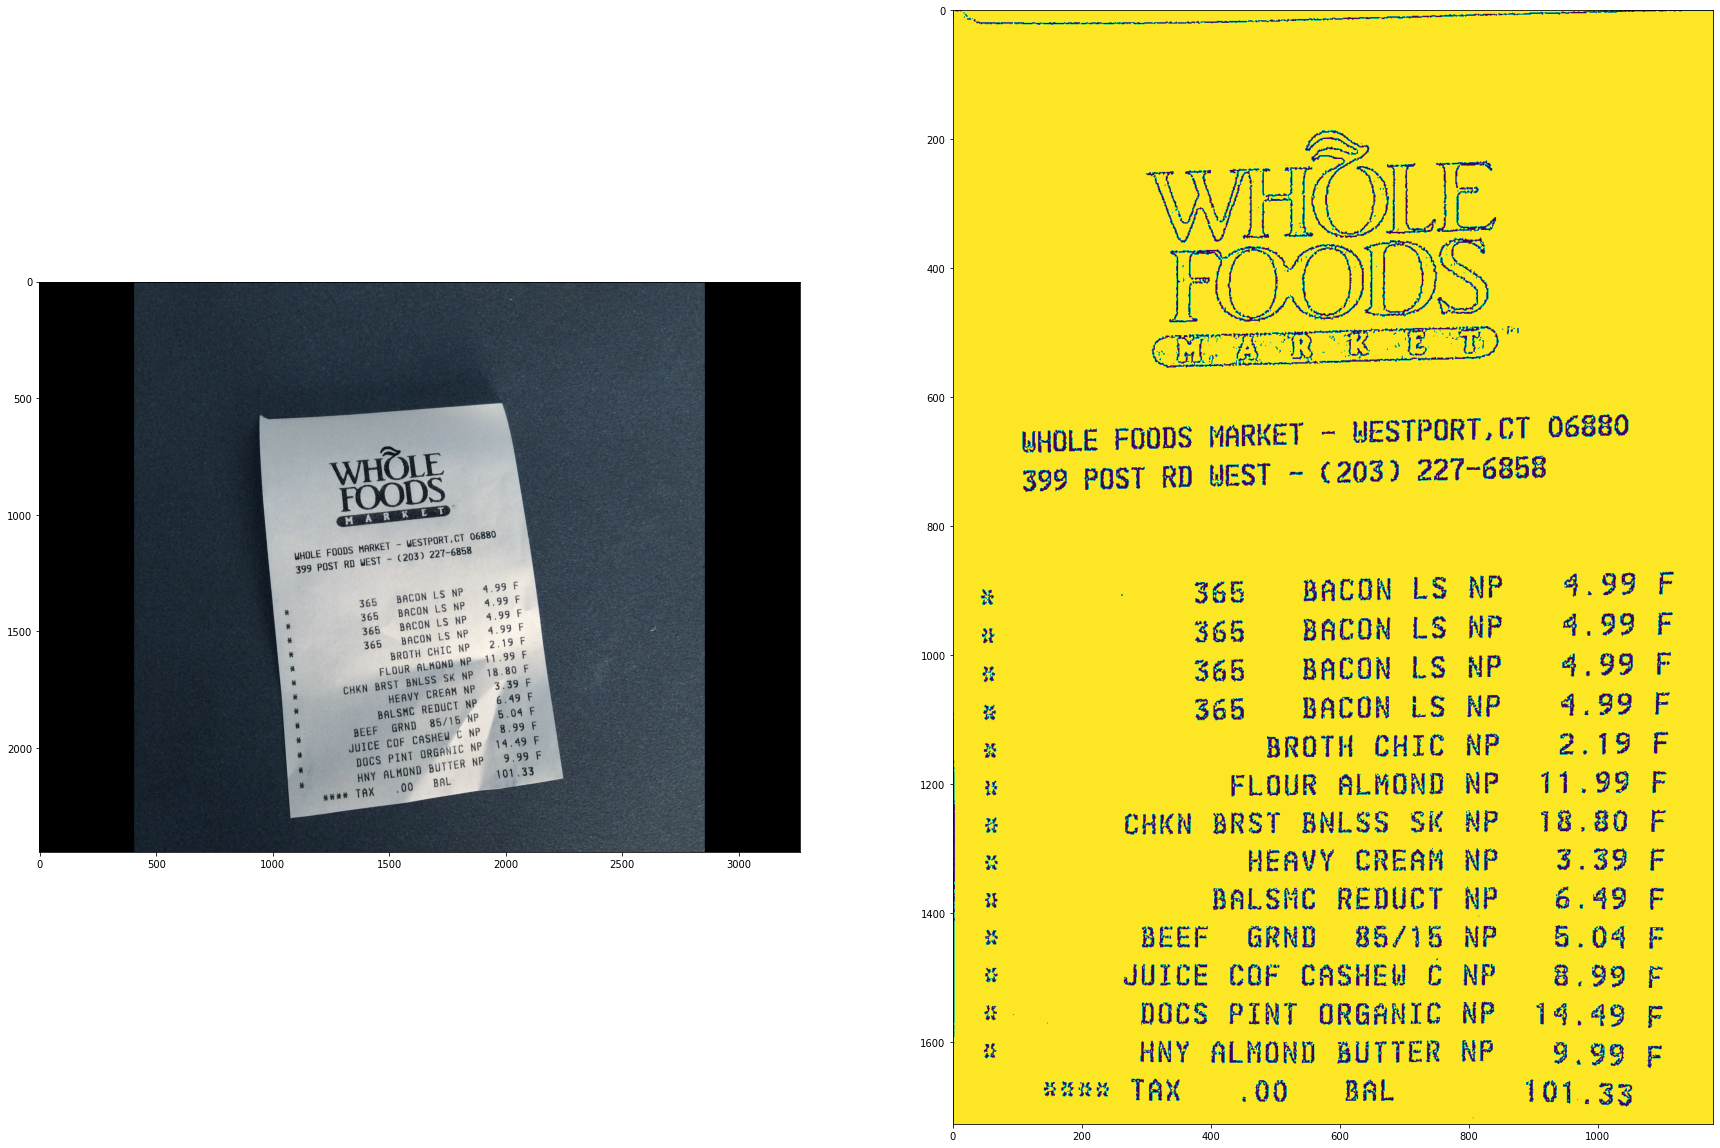

In [13]:
edge = warped.copy()
thresh = cv2.threshold(edge, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

_, axs = plt.subplots(1, 2, figsize=(30, 30))
axs = axs.flatten()
for img, ax in zip([orig, thresh], axs):
    ax.imshow(img)
plt.show()


In [14]:
#by using print we avoid a single string containing various /n
print(pytesseract.image_to_string(thresh, lang='eng', config='--psm 6'))

WAL, \ as

WHOL

FOODS

It oy Neel? bo)

GLARE"
WHOLE FOODS MARKET - WESTPORT,CT 06880
399 POST RD WEST ~ (203) 227-6858
x 365 BACON LS NP 4.99 F
3 365 BACON LS NP 4.99 F
zt 365 BACON LS NP 4.99 F
x 365 BACON LS NP 4.99 F
rs BROTH CHIC NP 2.19 F
tt FLOUR ALMOND NP 11.99 F
# CHKN BRST BNLSS SK NP 18.80 F
x HEAVY CREAM NP 3.39 F
3 BALSNC REDUCT NP 6.49 F
i BEEF GRND 85/15 NP 5.04 F
JUICE COF CASHEW C NP 8.99 F
tt DOCS PINT ORGANIC NP 14,49 F
tt HNY ALMOND BUTTER NP 9.99 f£
wane TAX 00 BAL 101.33



Tesseract 2

In [24]:
def alignImage(image, rotate=None, resize=800):
  if rotate:
    image = imutils.rotate(image, 90)

  orig = image.copy()
  ratio = 1
  if resize:
    ratio = image.shape[0] / resize
    image = imutils.resize(image, height = resize)

  # convert the image to grayscale, blur it, and find edges
  # in the image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(gray, 75, 200)

  # find the contours in the edged image, keeping only the
  # largest ones, and initialize the screen contour
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
  
  found = None
  # loop over the contours
  for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
      screenCnt = approx
      found = 1
      break

  if found:
    # apply the four point transform to obtain a top-down
    # view of the original image
    aligned = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
  else:
    aligned = orig 

  return aligned

def finding_box (img):
  image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  #Otsu thresholding
  thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  # Defining a kernel length
  kernel_length = np.array(binary_image).shape[1]//50

  verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
  hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

  # Morphological operation to detect vertical lines from an image
  img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
  verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

  # Morphological operation to detect horizontal lines from an image
  img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
  horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
  
  return verticle_lines_img, horizontal_lines_img

def sort_contours(cnts, method="left-to-right"):
    '''
    sort_contours : Function to sort contours
    argument:
        cnts (array): image contours
        method(string) : sorting direction
    output:
        cnts(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def rect2Pts(rect):
   pts[0][0][0] = rect[0] 
   pts[0][0][1] = rect[1] 
   pts[1][0][0] = rect[0] + rect[2] 
   pts[1][0][1] = rect[1] 


 # a = np.array([[[ 973,  257]], [[ 464,  282]], [[ 529, 1128]], [[1101, 1045]]])

#print(order_points(a.reshape(4, 2)))

In [ ]:
args={}
args['image'] = 'images/receipt.jpg'

image = alignImage(cv2.imread(args["image"]), 90, 1200)

v_lines, h_lines = finding_box(image)

#Join horizontal and vertical images
alpha = 0.5
beta = 1.0 - alpha
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
img_final_bin = cv2.addWeighted(v_lines, alpha, h_lines, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
thresh, img_final_bin = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img_final_bin = cv2.GaussianBlur(img_final_bin, (5, 5), 0)
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, boundingBoxes = sort_contours(contours, "top-to-bottom")

line = (-20,-20,0,0)
h = 18
w = 0
for  rect in boundingBoxes[1:260]:
  print(rect)
  if rect[1] - line[1] > h:
    if line[1] != -20:
      print('line', line)
      cv2.rectangle(image, line, (255, 0, 0), 3) 
    line = rect
    h = line[3]
    w = line[2]
  else: 
    print ('height', rect[1] - line[1], h)
    #if rect starts before actual line in x
    if rect[0] < line[0]:
      w += line[0] - rect[0]
      line = (rect[0], line[1], w, line[3])

    #if rect ends after actual line in x
    if line[0] + w < rect[0] + rect[2]:
      w += (rect[0] + rect[2]) - (line[0] + w)
      line = (line[0], line[1], w, line[3])

    #if rect ends after actual line in y
    if line[1] + h < rect[1] + rect[3]:
      h += (rect[1] + rect[3]) - (line[1] + h)
      line = (line[0], line[1], line[2], h)

cv2.rectangle(image, line, (255, 0, 0), 3) 
cv2.rectangle(image, (866, 665, 13, 37), (0, 255, 0), 3) 

plt.figure(figsize=(20,10))
plt.imshow(image)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


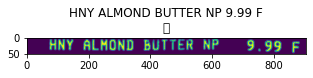

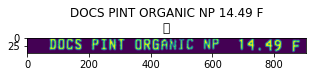

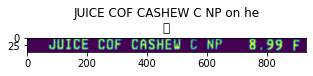

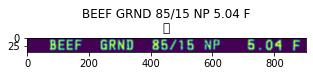

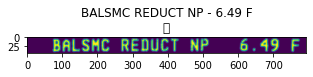

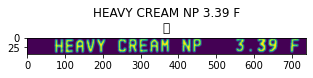

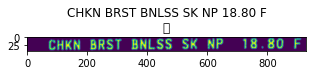

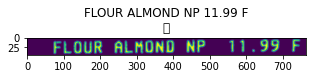

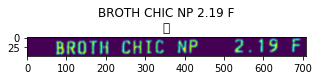

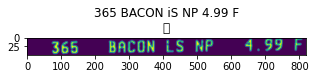

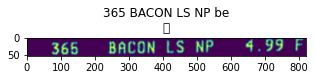

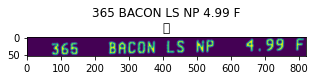

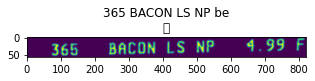

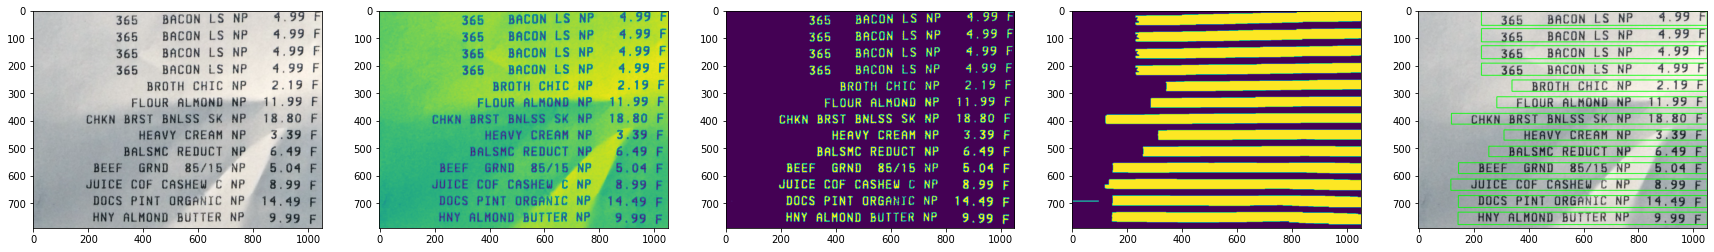

In [33]:
# https://stackoverflow.com/questions/50777688/finding-contours-with-lines-of-text-in-opencv
# 1. Find the optimum threshold to binarize your image. I used Otsu threshold.
# 2. Find the suitable morphological operation that will form a single region along the horizontal direction. Choose a kernel that is larger in width than the height.
# 3. Draw bounding boxes over the resulting contours
args={}
args['image'] = 'images/receipt.jpg'

image = alignImage(cv2.imread(args["image"]), 90, 1200)

#line (0, 875, 1112, 755)
#crop_img = img[y:y+h, x:x+w]
cropped = image[865:(865 + 790), 70:(70+1050)]

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)  
#gray = cv2.GaussianBlur(gray, (5, 5), 0)

#--- performing Otsu threshold ---
ret,thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY_INV)

#--- choosing the right kernel
#--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
#--- and 150 columns to join neighboring letters in words and neighboring words
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (150, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 1)

#---Finding contours ---
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

final = cropped.copy()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  if w > 150:
    tmp = thresh[y-3:(y-3+h+6), x:(x+w)]
    tmp = cv2.GaussianBlur(tmp, (7, 7), 0)
    title = pytesseract.image_to_string(tmp, lang='eng', config='--psm 6')
    cv2.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)
#    print(title)
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.imshow(tmp)

_, axs = plt.subplots(1, 5, figsize=(30, 30))
axs = axs.flatten()
for img, ax in zip([cropped, gray, thresh, dilation, final], axs):
    ax.imshow(img)
plt.show()


In [19]:
a = np.array([[[ 973,  257]], [[ 464,  282]], [[ 529, 1128]], [[1101, 1045]]])

print(order_points(a.reshape(4, 2)))



print(cnt[0][0][0], cnt[0][0][1])
cnt

[[ 464.  282.]
 [ 973.  257.]
 [1101. 1045.]
 [ 529. 1128.]]
955 4


array([[[955,   4]],

       [[954,   5]],

       [[953,   5]],

       ...,

       [[958,   4]],

       [[957,   4]],

       [[956,   4]]], dtype=int32)

In [69]:
def find_good_contours_thres(conts, alpha = 0.002):
    '''
    Function to find threshold of good contours on basis of 10% of maximum area
    Input: Contours, threshold for removing noises
    Output: Contour area threshold
    
    For image dim 3307*4676
    alpha(text_segment) = 0.01
    alpha(extract_line) = 0.002
    '''
    #Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    #alpha is controlling paramter    
    thres = alpha * max(areas)[0]
    
    return thres

def extract_line(image, beta=0.7, alpha=0.002, show = True):
    '''
    Function to extracts the line from the image   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : Parameter to differentiate line
        alpha (0-1) : Parameter to select good contours
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    #Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Binary thresholding and inverting at 127
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    #Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    #Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #Dilating the cleaned image for better detection of line in cases where
    #exponents are little up the line
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ##find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    #Extending uppers and lowers indexes to avoid cutting of chars of lines
    #Extended more uppers by 33% as exponential might lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    #Combining rogue exponentials into their deserving lines. This happens when
    #exponential and lines are separated by some distance
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #For changing color of intermediate lines, keeping count
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        #print(left,right)
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]

def extract_box(img, show=True):
    '''
    Function to extract the boxes in the ruled worksheet
    Input : Image with rectangle, show figures
    Output : Extract workspaces locations
    '''
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Otsu thresholding
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Defining a kernel length
    kernel_length = np.array(binary_image).shape[1]//80

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
    
    #Join horizontal and vertical images
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #Find and sort the contours
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area) #sorted area
    
    workspace_contours = []    
    #Find the correct boxes where area is between 40% and 50% of the largest rectangle
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    #A list to containg rectangle locs
    rectangle_locs =[]   
    
    #finding out locations of rectangle
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(7,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs    



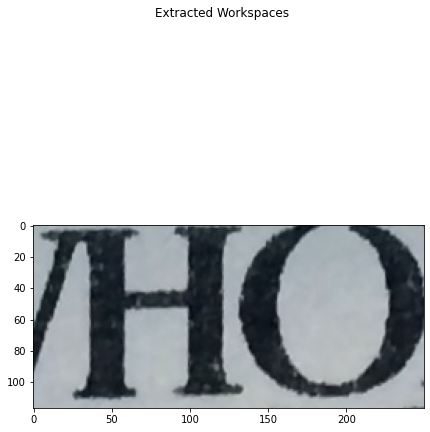

ValueError: ignored

In [71]:
args={}
args['image'] = 'images/receipt.jpg'

image = alignImage(cv2.imread(args["image"]), 90)

workspaces = extract_box(image)

for r,rect in enumerate(workspaces):
        #Cropping boxes for sending to line detection module
        box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        H,W = box.shape[:2]
        #Extracting lines present in the boxes
        cleaned_orig,y1s,y2s = extract_line(box, show=False)
        x1s = [0]*len(y1s)
        x2s = [W]*len(y1s)
        
        df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
        df.columns = ['y1','y2','x1','x2']
        df['box_num'] = r

        df_lines= pd.concat([df_lines, df])
    
        dict_clean_img.update({r:cleaned_orig})
        dict_img.update({r:box})
        
        print(df)